<a href="https://colab.research.google.com/github/emmetorior/CN7030-/blob/main/ASSN_CN7050_FINAL4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install findspark
!pip install --upgrade pyspark pyarrow pandas
from google.colab import drive

In [2]:
#d=[]
#while(1):
#  d.append('1')

In [3]:
import pandas as pd
import pyspark
import pyarrow as pa
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import array_contains
from pyspark.sql.functions import col, explode, split, array, lit
from pyspark.ml.feature import CountVectorizer, IDF
import ast


Check Files Exist and Are Readable.

In [4]:
import os
parquet_validation_file = "/content/drive/MyDrive/Colab Notebooks/CN7050/validation-00000-of-00001.parquet"
print(os.path.exists(parquet_validation_file))

parquet_test_file = "/content/drive/MyDrive/Colab Notebooks/CN7050/test-00000-of-00001.parquet"
print(os.path.exists(parquet_test_file))

parquet_train_file = "/content/drive/MyDrive/Colab Notebooks/CN7050/train-00000-of-00001.parquet"
print(os.path.exists(parquet_train_file))

True
True
True


Load files into Spark. We have a train, test and validation file. Each one is loaded in from the parquet downloaded from huggingface.co

SET UP A SPARK SESSION AND SET OPTIONS

In [5]:
spark = SparkSession.Builder().master("local[*]").getOrCreate()
spark.conf.set("spark.sql.parquet.mergeSchema", "false")
spark.conf.set("spark.sql.parquet.binaryAsString", "true")

In [6]:
dfs_train = spark.read.format("parquet").option("mergeSchema", "false").load(parquet_train_file)
dfs_test = spark.read.format("parquet").option("mergeSchema", "false").load(parquet_test_file)
dfs_validation = spark.read.format("parquet").option("mergeSchema", "false").load(parquet_validation_file)

Check the file contents

In [7]:
dfs_train.show(5)
dfs_test.show(5)
dfs_validation.show(5)

+---------+---------+-----------+----------------+--------------------+--------------------+--------------------+
|       id|org_index|data_source|        industry|                text|              labels|         label_codes|
+---------+---------+-----------+----------------+--------------------+--------------------+--------------------+
|301972057|      600| Trustpilot|Price Comparison|My experience is ...|[[Staff support: ...|['staff-support.a...|
|301982453|      514|Google Play|         Banking|I love it so hand...|[[Company brand: ...|['company-brand.g...|
|301980653|      369|Google Play|    Ride Hailing|  Sometimes it takes|[[Company brand: ...|['company-brand.g...|
|301979991|      727|Apple Store|         Fashion|This is the worst...|[[Logistics rides...|['logistics-rides...|
|301984330|      549|Google Play|  Travel Booking|So easy & loads o...|[[Company brand: ...|['company-brand.g...|
+---------+---------+-----------+----------------+--------------------+-----------------

File was not loading. Implemented a Workaround by converting the pandas version

1.   List item
2.   List item

of the parquet file converted to CSV and read into spark to create a spark dataframe. Maybe delete this segment later as problem was resolved.  

*italicized text*

In [8]:
print("Training file row count:", dfs_train.count())
dfs_train.printSchema()
print("Testing file row count:", dfs_test.count())
dfs_test.printSchema()
print("Validation file row count:", dfs_validation.count())
dfs_validation.printSchema()

Training file row count: 7930
root
 |-- id: long (nullable = true)
 |-- org_index: long (nullable = true)
 |-- data_source: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- text: string (nullable = true)
 |-- labels: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- label_codes: string (nullable = true)

Testing file row count: 1587
root
 |-- id: long (nullable = true)
 |-- org_index: long (nullable = true)
 |-- data_source: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- text: string (nullable = true)
 |-- labels: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- label_codes: string (nullable = true)

Validation file row count: 1057
root
 |-- id: long (nullable = true)
 |-- org_index: long (nullable = true)
 |-- data_source: string (nullable = true)
 |-- industry: string (nullable = true

In [9]:
#findspark.init()
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import col, sum


In [10]:
null_counts_train = dfs_train.select([sum(col(c).isNull().cast("int")).alias(c) for c in dfs_train.columns])
null_counts_train.show()
null_counts_test = dfs_test.select([sum(col(c).isNull().cast("int")).alias(c) for c in dfs_test.columns])
null_counts_test.show()
null_counts_validation = dfs_validation.select([sum(col(c).isNull().cast("int")).alias(c) for c in dfs_validation.columns])
null_counts_validation.show()

+---+---------+-----------+--------+----+------+-----------+
| id|org_index|data_source|industry|text|labels|label_codes|
+---+---------+-----------+--------+----+------+-----------+
|  0|        0|          0|       0|   0|     0|          0|
+---+---------+-----------+--------+----+------+-----------+

+---+---------+-----------+--------+----+------+-----------+
| id|org_index|data_source|industry|text|labels|label_codes|
+---+---------+-----------+--------+----+------+-----------+
|  0|        0|          0|       0|   0|     0|          0|
+---+---------+-----------+--------+----+------+-----------+

+---+---------+-----------+--------+----+------+-----------+
| id|org_index|data_source|industry|text|labels|label_codes|
+---+---------+-----------+--------+----+------+-----------+
|  0|        0|          0|       0|   0|     0|          0|
+---+---------+-----------+--------+----+------+-----------+



In [11]:
# ACD
from pyspark.sql.functions import col, array_contains, lit, explode, udf
from pyspark.ml.classification import LogisticRegression, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, HashingTF, IDF, Tokenizer
from pyspark.sql.types import ArrayType, StringType
import ast

INSERT 0

SVM - Category: staff-support.attitude-of-staff, F1: 0.8981648026442215, Precision: 0.8966377667587873, Recall: 0.8999999999999999
SVM - Category: company-brand.reviews, F1: 0.9677203938336014, Precision: 0.9651736040609137, Recall: 0.971
SVM - Category: company-brand.general-satisfaction, F1: 0.6661523809523809, Precision: 0.66659375, Recall: 0.6769999999999999
SVM - Category: company-brand.competitor, F1: 0.8884802807311581, Precision: 0.8785668878034555, Recall: 0.902
SVM - Category: logistics-rides.speed, F1: 0.8614310730294387, Precision: 0.8551839601038116, Recall: 0.87
SVM - Category: online-experience.app-website, F1: 0.7746932667101523, Precision: 0.7754421736473933, Recall: 0.776
SVM - Category: purchase-booking-experience.ease-of-use, F1: 0.7316663798542995, Precision: 0.7291313063319458, Recall: 0.736
SVM - Category: value.price-value-for-money, F1: 0.8587893006936105, Precision: 0.8532641726551125, Recall: 0.869
SVM - Category: value.discounts-promotions, F1: 0.92078004449

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.2434 - loss: 0.5302 - val_accuracy: 0.2890 - val_loss: 0.3387
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.2726 - loss: 0.3547 - val_accuracy: 0.2860 - val_loss: 0.3356
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2774 - loss: 0.3423 - val_accuracy: 0.2870 - val_loss: 0.3330
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.3052 - loss: 0.3352 - val_accuracy: 0.3550 - val_loss: 0.3301
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.3740 - loss: 0.3176 - val_accuracy: 0.3720 - val_loss: 0.3181
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4539 - loss: 0.3056 - val_accuracy: 0.4460 - val_loss: 0.3140
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4960 - loss: 0.2882 - val_accuracy: 0.4630 - val_loss: 0.3028
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5680 - loss: 0.2628 - val_accuracy: 0.479

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 336ms/step - accuracy: 0.2729 - loss: 0.5560 - val_accuracy: 0.2860 - val_loss: 0.3396
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.3017 - loss: 0.3477 - val_accuracy: 0.2860 - val_loss: 0.3396
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 303ms/step - accuracy: 0.2958 - loss: 0.3425 - val_accuracy: 0.3850 - val_loss: 0.3317
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - accuracy: 0.3109 - loss: 0.3310 - val_accuracy: 0.3520 - val_loss: 0.3249
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.3071 - loss: 0.3191 - val_accuracy: 0.3410 - val_loss: 0.3205
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.3546 - loss: 0.3179 - val_accuracy: 0.4090 - val_loss: 0.3201
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 313ms/step - accuracy: 0.5041 - loss: 0.2861 - val_accuracy: 0.4130 - val_loss: 0.3093
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - accuracy: 0.5743 - loss: 0.2551 - val_

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

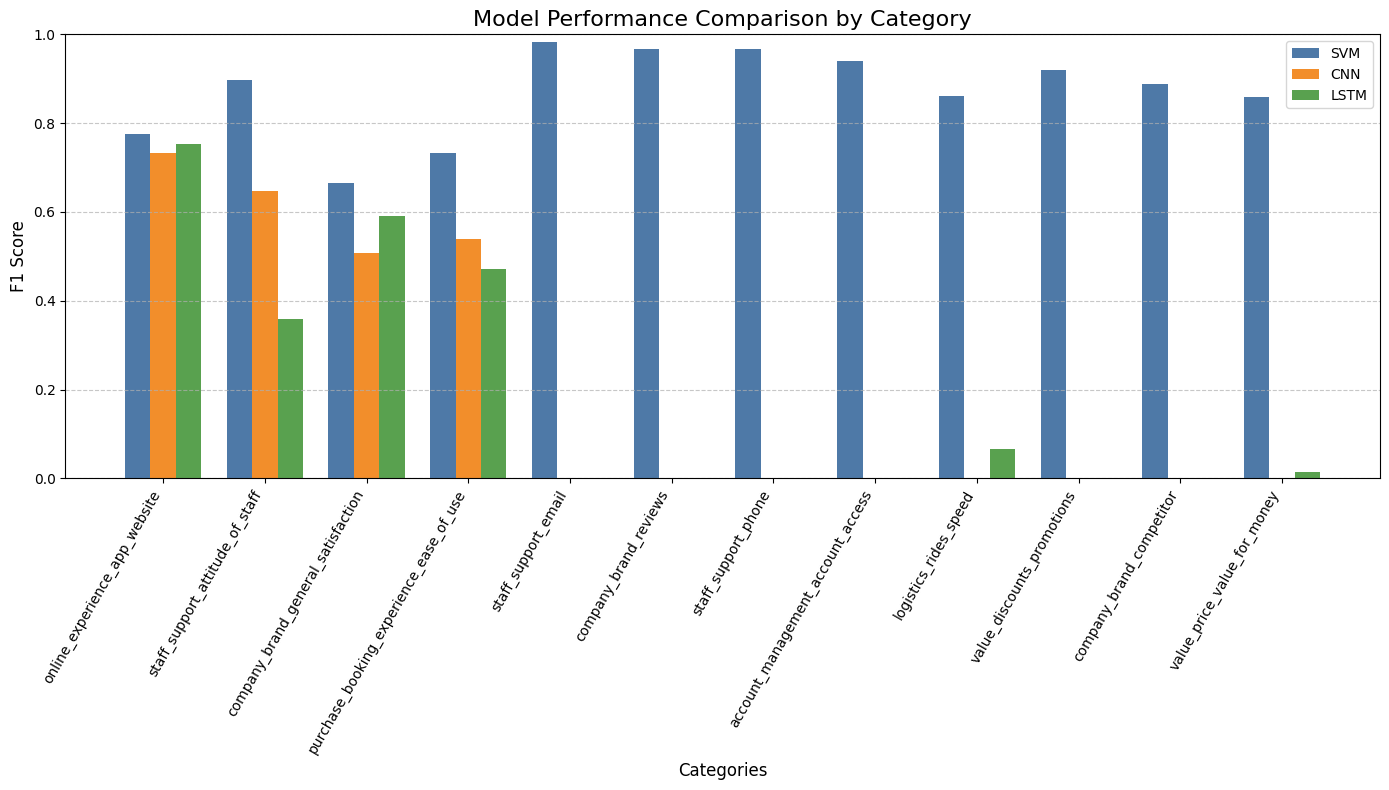

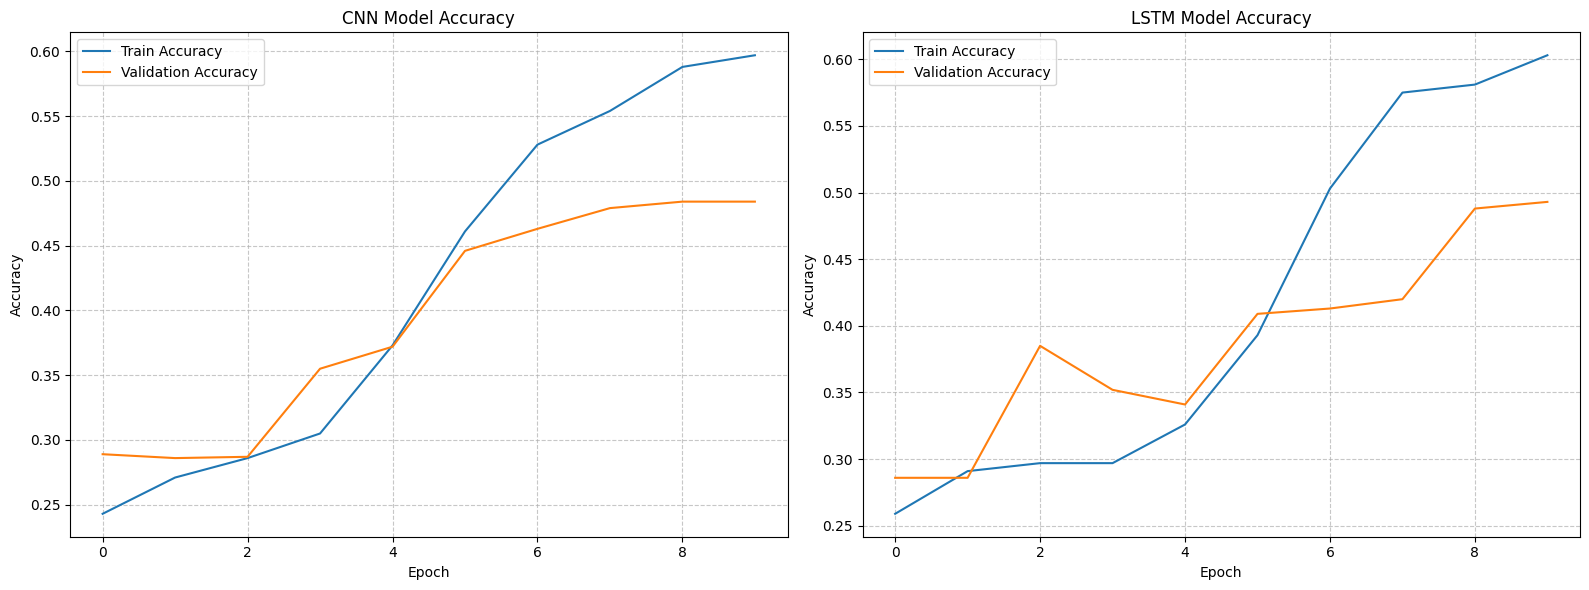

In [12]:
from pyspark.sql.functions import col, array_contains, explode, udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import VectorAssembler, HashingTF, IDF, Tokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import ast
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

# Step 1: Extract and clean categories (same as before)
@udf(returnType=ArrayType(StringType()))
def extract_categories(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        return [code.rsplit('.', 1)[0] for code in codes]
    return []

# Apply the UDF to extract categories
dfs_train_clean = dfs_train.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_test_clean = dfs_test.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_validation_clean = dfs_validation.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)

# Step 2: Get all unique categories with consistent naming
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

# Step 3: Create binary indicator columns (same as before)
for category in all_categories:
    # Use the original category name in the column name to avoid confusion
    col_name = f"has_{category.replace('-', '_').replace('.', '_')}"
    dfs_train_clean = dfs_train_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))

# Cache DataFrames (same as before)
dfs_train_clean.cache()
dfs_test_clean.cache()
dfs_validation_clean.cache()

# Step 4: TF-IDF Features for traditional ML model (SVM)
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=1000)
idf = IDF(inputCol="raw_features", outputCol="tfidf_features", minDocFreq=2)

# Apply transformations
train_tokenized = tokenizer.transform(dfs_train_clean)
test_tokenized = tokenizer.transform(dfs_test_clean)
train_hashed = hashingTF.transform(train_tokenized)
test_hashed = hashingTF.transform(test_tokenized)
idf_model = idf.fit(train_hashed)
train_tfidf = idf_model.transform(train_hashed)
test_tfidf = idf_model.transform(test_hashed)

# Step 5: Prepare data for deep learning models (CNN and LSTM)
# Convert to pandas for easier processing
train_pandas = dfs_train_clean.toPandas()
test_pandas = dfs_test_clean.toPandas()
validation_pandas = dfs_validation_clean.toPandas()

# Prepare text data for deep learning models
keras_tokenizer = KerasTokenizer(num_words=10000)
keras_tokenizer.fit_on_texts(train_pandas['text'])

# Convert text to sequences
train_sequences = keras_tokenizer.texts_to_sequences(train_pandas['text'])
test_sequences = keras_tokenizer.texts_to_sequences(test_pandas['text'])
validation_sequences = keras_tokenizer.texts_to_sequences(validation_pandas['text'])

# Pad sequences to ensure uniform length
max_seq_length = 100
train_data = pad_sequences(train_sequences, maxlen=max_seq_length)
test_data = pad_sequences(test_sequences, maxlen=max_seq_length)
validation_data = pad_sequences(validation_sequences, maxlen=max_seq_length)

# Prepare multi-label targets for deep learning
feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]
train_labels = train_pandas[feature_cols].values
test_labels = test_pandas[feature_cols].values
validation_labels = validation_pandas[feature_cols].values

# Step 6: Build and train different models

# 6.1: SVM Model for each category (similar to previous code)
svm_results = {}

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    col_name = f"has_{clean_cat}"

    # Create label column for this specific category
    train_data_svm = train_tfidf.withColumn("label", col(col_name))
    test_data_svm = test_tfidf.withColumn("label", col(col_name))

    # Use only TF-IDF features for prediction
    assembler = VectorAssembler(inputCols=["tfidf_features"], outputCol="features")
    train_assembled = assembler.transform(train_data_svm).select("features", "label")
    test_assembled = assembler.transform(test_data_svm).select("features", "label")

    # Train binary classifier
    svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=20, regParam=0.1)
    svm_model = svm.fit(train_assembled)

    # Make predictions
    predictions = svm_model.transform(test_assembled)

    # Evaluate
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1 = evaluator.evaluate(predictions)
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

    svm_results[category] = {"f1": f1, "precision": precision, "recall": recall}
    print(f"SVM - Category: {category}, F1: {f1}, Precision: {precision}, Recall: {recall}")

# 6.2: CNN Model for multi-label classification
def build_cnn_model(vocab_size, embedding_dim, max_length, num_categories):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_categories, activation='sigmoid'))  # Sigmoid for multi-label
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Build and train CNN model
vocab_size = min(10000, len(keras_tokenizer.word_index) + 1)
embedding_dim = 100
num_categories = len(all_categories)

cnn_model = build_cnn_model(vocab_size, embedding_dim, max_seq_length, num_categories)
print(cnn_model.summary())

# Train with early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history_cnn = cnn_model.fit(
    train_data, train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(validation_data, validation_labels),
    callbacks=[early_stopping]
)

# Evaluate CNN model
cnn_predictions = cnn_model.predict(test_data)
cnn_predictions_binary = (cnn_predictions > 0.5).astype(int)

# Calculate metrics for CNN
cnn_results = {}
for i, category in enumerate(all_categories):
    f1 = f1_score(test_labels[:, i], cnn_predictions_binary[:, i])
    report = classification_report(test_labels[:, i], cnn_predictions_binary[:, i], output_dict=True)
    cnn_results[category] = {
        "f1": f1,
        "precision": report['1']['precision'] if 1 in report else 0,
        "recall": report['1']['recall'] if 1 in report else 0
    }
    print(f"CNN - Category: {category}, F1: {f1}")

# 6.3: LSTM Model for multi-label classification
def build_lstm_model(vocab_size, embedding_dim, max_length, num_categories):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_categories, activation='sigmoid'))  # Sigmoid for multi-label
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Build and train LSTM model
lstm_model = build_lstm_model(vocab_size, embedding_dim, max_seq_length, num_categories)
print(lstm_model.summary())

# Train with early stopping
history_lstm = lstm_model.fit(
    train_data, train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(validation_data, validation_labels),
    callbacks=[early_stopping]
)

# Evaluate LSTM model
lstm_predictions = lstm_model.predict(test_data)
lstm_predictions_binary = (lstm_predictions > 0.5).astype(int)

# Calculate metrics for LSTM
lstm_results = {}
for i, category in enumerate(all_categories):
    f1 = f1_score(test_labels[:, i], lstm_predictions_binary[:, i])
    report = classification_report(test_labels[:, i], lstm_predictions_binary[:, i], output_dict=True)
    lstm_results[category] = {
        "f1": f1,
        "precision": report['1']['precision'] if 1 in report else 0,
        "recall": report['1']['recall'] if 1 in report else 0
    }
    print(f"LSTM - Category: {category}, F1: {f1}")

# Step 7: Visualize and compare model performance
def plot_model_comparison(svm_results, cnn_results, lstm_results, all_categories):
    # Prepare data
    categories = [cat.replace('-', '_').replace('.', '_') for cat in all_categories]
    svm_f1 = [svm_results[cat]['f1'] for cat in all_categories]
    cnn_f1 = [cnn_results[cat]['f1'] for cat in all_categories]
    lstm_f1 = [lstm_results[cat]['f1'] for cat in all_categories]

    # Sort by average F1 score
    avg_f1 = [(svm_f1[i] + cnn_f1[i] + lstm_f1[i])/3 for i in range(len(all_categories))]
    indices = np.argsort(avg_f1)[::-1]

    categories = [categories[i] for i in indices]
    svm_f1 = [svm_f1[i] for i in indices]
    cnn_f1 = [cnn_f1[i] for i in indices]
    lstm_f1 = [lstm_f1[i] for i in indices]

    # Plot
    x = np.arange(len(categories))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.bar(x - width, svm_f1, width, label='SVM', color='#4e79a7')
    ax.bar(x, cnn_f1, width, label='CNN', color='#f28e2b')
    ax.bar(x + width, lstm_f1, width, label='LSTM', color='#59a14f')

    ax.set_xlabel('Categories', fontsize=12)
    ax.set_ylabel('F1 Score', fontsize=12)
    ax.set_title('Model Performance Comparison by Category', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=60, ha='right')
    ax.set_ylim(0, 1.0)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300)
    plt.show()

# Plot training history for deep learning models
def plot_training_history(history_cnn, history_lstm):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # CNN training history
    ax1.plot(history_cnn.history['accuracy'], label='Train Accuracy')
    ax1.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('CNN Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(linestyle='--', alpha=0.7)

    # LSTM training history
    ax2.plot(history_lstm.history['accuracy'], label='Train Accuracy')
    ax2.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('LSTM Model Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300)
    plt.show()

# Execute visualization functions
plot_model_comparison(svm_results, cnn_results, lstm_results, all_categories)
plot_training_history(history_cnn, history_lstm)


INSERT

In [13]:
# Step 1: Extract and clean categories - use a consistent naming convention
@udf(returnType=ArrayType(StringType()))
def extract_categories(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        return [code.rsplit('.', 1)[0] for code in codes]
    return []

# Apply the UDF to extract categories
dfs_train_clean = dfs_train.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_test_clean = dfs_test.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_validation_clean = dfs_validation.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)

# Step 2: Get all unique categories with consistent naming
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

# Step 3: Create binary indicator columns with consistent naming
for category in all_categories:
    # Use the original category name in the column name to avoid confusion
    col_name = f"has_{category.replace('-', '_').replace('.', '_')}"
    dfs_train_clean = dfs_train_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))

# Cache DataFrames
dfs_train_clean.cache()
dfs_test_clean.cache()
dfs_validation_clean.cache()
dfs_train_clean.show(10)

# Step 4: Text vectorization with TF-IDF
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=1000)
idf = IDF(inputCol="raw_features", outputCol="tfidf_features", minDocFreq=2)

# Apply transformations
train_tokenized = tokenizer.transform(dfs_train_clean)
test_tokenized = tokenizer.transform(dfs_test_clean)
train_hashed = hashingTF.transform(train_tokenized)
test_hashed = hashingTF.transform(test_tokenized)
idf_model = idf.fit(train_hashed)
train_tfidf = idf_model.transform(train_hashed)
test_tfidf = idf_model.transform(test_hashed)

# Step 5: Select the correct feature columns based on the actual column names
feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]

# Step 6: Build a multi-label classifier for each category
# For each category, train a separate binary classifier
results = {}

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    col_name = f"has_{clean_cat}"

    # Create label column for this specific category
    train_data = train_tfidf.withColumn("label", col(col_name))
    test_data = test_tfidf.withColumn("label", col(col_name))

    # Use only TF-IDF features for prediction
    assembler = VectorAssembler(inputCols=["tfidf_features"], outputCol="features")
    train_assembled = assembler.transform(train_data).select("features", "label")
    test_assembled = assembler.transform(test_data).select("features", "label")

    # Train binary classifier
    svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=20, regParam=0.1)
    svm_model = svm.fit(train_assembled)

    # Make predictions
    predictions = svm_model.transform(test_assembled)

    # Evaluate
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1 = evaluator.evaluate(predictions)
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

    results[category] = {"f1": f1, "precision": precision, "recall": recall}
    print(f"Category: {category}, F1: {f1}, Precision: {precision}, Recall: {recall}")

+---------+---------+-----------+----------------+--------------------+--------------------+--------------------+--------------------+-----------------------------------+-------------------------+--------------------------------------+----------------------------+-------------------------+---------------------------------+-------------------------------------------+-------------------------------+------------------------------+-------------------------------------+-----------------------+-----------------------+
|       id|org_index|data_source|        industry|                text|              labels|         label_codes|          categories|has_staff_support_attitude_of_staff|has_company_brand_reviews|has_company_brand_general_satisfaction|has_company_brand_competitor|has_logistics_rides_speed|has_online_experience_app_website|has_purchase_booking_experience_ease_of_use|has_value_price_value_for_money|has_value_discounts_promotions|has_account_management_account_access|has_staff_sup

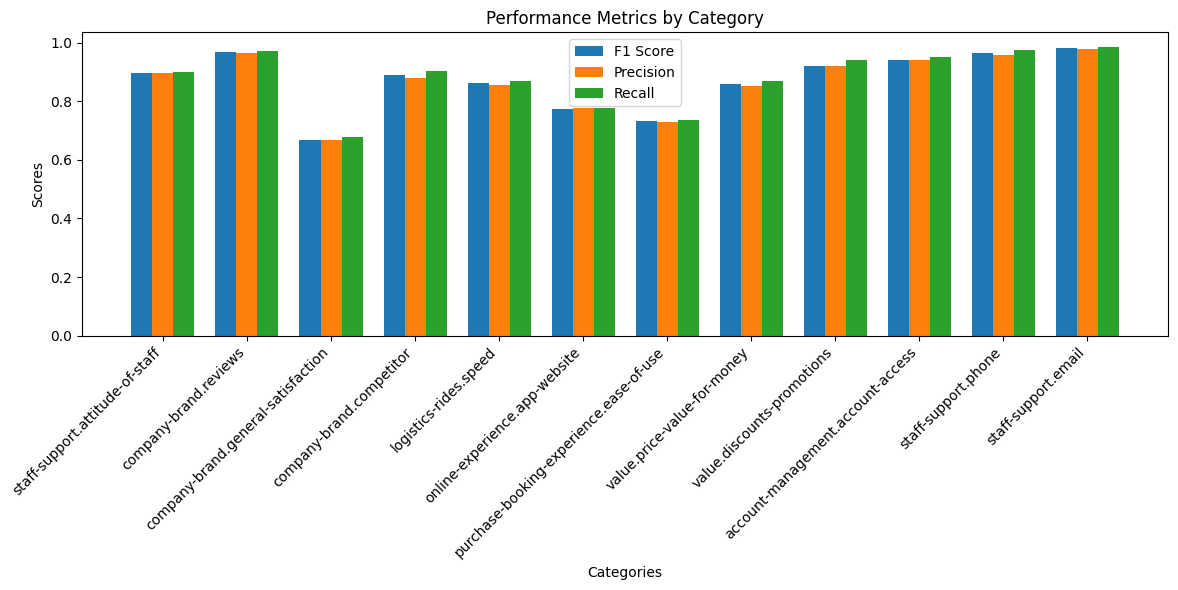

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'results' is the dictionary containing performance metrics
categories = list(results.keys())
f1_scores = [results[cat]['f1'] for cat in categories]
precision_scores = [results[cat]['precision'] for cat in categories]
recall_scores = [results[cat]['recall'] for cat in categories]

# Create a DataFrame for easy plotting
df = pd.DataFrame({
    'Category': categories,
    'F1 Score': f1_scores,
    'Precision': precision_scores,
    'Recall': recall_scores
})

# Plot
plt.figure(figsize=(12, 6))
x = np.arange(len(categories))
width = 0.25

plt.bar(x - width, f1_scores, width, label='F1 Score')
plt.bar(x, precision_scores, width, label='Precision')
plt.bar(x + width, recall_scores, width, label='Recall')

plt.xlabel('Categories')
plt.ylabel('Scores')
plt.title('Performance Metrics by Category')
plt.xticks(x, categories, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('category_performance.png')
plt.show()

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Assuming 'results' is your dictionary of performance metrics
# and 'all_categories' contains your category names

# 1. Performance Metrics by Category
def plot_category_performance(results, all_categories):
    # Prepare data
    categories = [cat.replace('-', '_').replace('.', '_') for cat in all_categories]
    metrics = pd.DataFrame({
        'Category': categories,
        'F1 Score': [results[cat]['f1'] for cat in all_categories],
        'Precision': [results[cat]['precision'] for cat in all_categories],
        'Recall': [results[cat]['recall'] for cat in all_categories]
    })

    # Sort by F1 score
    metrics = metrics.sort_values('F1 Score', ascending=False)

    # Plot
    plt.figure(figsize=(14, 8))
    x = np.arange(len(metrics))
    width = 0.25

    plt.bar(x - width, metrics['F1 Score'], width, label='F1 Score', color='#4e79a7')
    plt.bar(x, metrics['Precision'], width, label='Precision', color='#f28e2b')
    plt.bar(x + width, metrics['Recall'], width, label='Recall', color='#59a14f')

    plt.xlabel('Categories', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Performance Metrics by Category', fontsize=16)
    plt.xticks(x, metrics['Category'], rotation=60, ha='right')
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('category_performance.png', dpi=300)
    plt.show()

# 2. Category Distribution Heatmap
def plot_category_distribution(df_train):
    # Get category counts
    category_counts = {}
    for category in all_categories:
        col_name = f"has_{category.replace('-', '_').replace('.', '_')}"
        category_counts[category] = df_train.filter(col(col_name) == 1).count()

    # Convert to DataFrame
    counts_df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])
    counts_df = counts_df.sort_values('Count', ascending=False)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y='Category', data=counts_df, palette='viridis')
    plt.title('Distribution of Categories in Training Data', fontsize=16)
    plt.xlabel('Number of Instances', fontsize=12)
    plt.ylabel('Category', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('category_distribution.png', dpi=300)
    plt.show()

# 3. Co-occurrence Matrix Heatmap
def plot_category_cooccurrence(df_train):
    # Convert to pandas for easier processing
    feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]
    df_pandas = df_train.select(feature_cols).toPandas()

    # Calculate co-occurrence
    cooccurrence = df_pandas.T.dot(df_pandas)

    # Plot
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(cooccurrence, dtype=bool))
    with sns.axes_style("white"):
        sns.heatmap(cooccurrence, mask=mask, annot=True, fmt="d", cmap="YlGnBu",
                    xticklabels=all_categories, yticklabels=all_categories)
    plt.title('Category Co-occurrence Matrix', fontsize=16)
    plt.xticks(rotation=60, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('category_cooccurrence.png', dpi=300)
    plt.show()

# 4. Word Importance Visualization
def plot_word_importance(vectorizer, model, category, top_n=20):
    """Visualize the most important words for a specific category."""
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()

    # Get coefficients
    coef = model.coef_[0]

    # Create DataFrame with words and their importance
    word_importance = pd.DataFrame(
        {'Word': feature_names, 'Importance': coef}
    ).sort_values('Importance', ascending=False)

    # Plot top positive and negative words
    plt.figure(figsize=(12, 8))

    # Top positive words (indicating presence of category)
    plt.subplot(1, 2, 1)
    top_positive = word_importance.head(top_n)
    sns.barplot(x='Importance', y='Word', data=top_positive, palette='Blues_d')
    plt.title(f'Top {top_n} Words Indicating "{category}"', fontsize=14)
    plt.xlabel('Importance Score', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Top negative words (indicating absence of category)
    plt.subplot(1, 2, 2)
    top_negative = word_importance.tail(top_n).sort_values('Importance')
    sns.barplot(x='Importance', y='Word', data=top_negative, palette='Reds_d')
    plt.title(f'Top {top_n} Words Against "{category}"', fontsize=14)
    plt.xlabel('Importance Score', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f'word_importance_{category}.png', dpi=300)
    plt.show()

# 5. Confusion Matrix for Each Category
def plot_confusion_matrices(y_true, y_pred, all_categories):
    """Plot confusion matrices for all categories."""
    # Create a grid of confusion matrices
    n_categories = len(all_categories)
    n_cols = 3
    n_rows = (n_categories + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten()

    for i, category in enumerate(all_categories):
        if i < len(axes):
            # Get true and predicted values for this category
            true = y_true[:, i]
            pred = y_pred[:, i]

            # Calculate confusion matrix
            cm = confusion_matrix(true, pred)

            # Plot
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
            axes[i].set_title(f'Confusion Matrix: {category}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('True')
            axes[i].set_xticklabels(['No', 'Yes'])
            axes[i].set_yticklabels(['No', 'Yes'])

    # Hide any unused subplots
    for i in range(n_categories, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300)
    plt.show()

# 6. ROC Curves
def plot_roc_curves(models, X_test, y_test, all_categories):
    """Plot ROC curves for all category classifiers."""
    from sklearn.metrics import roc_curve, auc

    plt.figure(figsize=(10, 8))

    for i, category in enumerate(all_categories):
        # Get true values
        y_true = y_test[:, i]

        # Get predictions
        y_score = models[category].decision_function(X_test)

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        # Plot
        plt.plot(fpr, tpr, lw=2,
                 label=f'{category} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Categories')
    plt.legend(loc="lower right")
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('roc_curves.png', dpi=300)
    plt.show()

# 7. Learning Curve
def plot_learning_curve(model, X, y, category, cv=5):
    """Plot learning curve to show model performance with increasing data."""
    from sklearn.model_selection import learning_curve

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1')

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
    plt.xlabel('Training set size')
    plt.ylabel('F1 Score')
    plt.title(f'Learning Curve for {category}')
    plt.legend(loc='best')
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'learning_curve_{category}.png', dpi=300)
    plt.show()

INSERT 2


+---------+---------+-----------+----------------+--------------------+--------------------+--------------------+--------------------+-----------------------------------+-------------------------+--------------------------------------+----------------------------+-------------------------+---------------------------------+-------------------------------------------+-------------------------------+------------------------------+-------------------------------------+-----------------------+-----------------------+
|       id|org_index|data_source|        industry|                text|              labels|         label_codes|          categories|has_staff_support_attitude_of_staff|has_company_brand_reviews|has_company_brand_general_satisfaction|has_company_brand_competitor|has_logistics_rides_speed|has_online_experience_app_website|has_purchase_booking_experience_ease_of_use|has_value_price_value_for_money|has_value_discounts_promotions|has_account_management_account_access|has_staff_sup

<ipython-input-15-16845fc4ee7b>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Category', data=counts_df, palette='viridis')


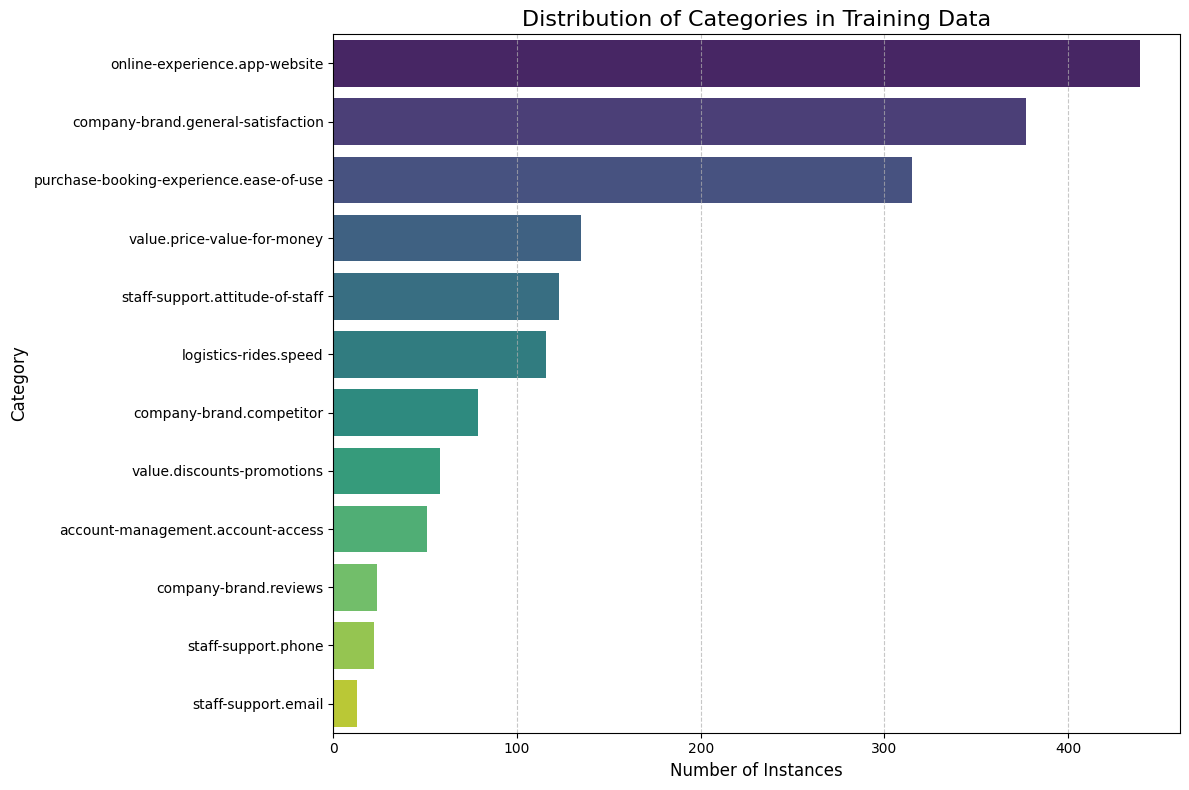

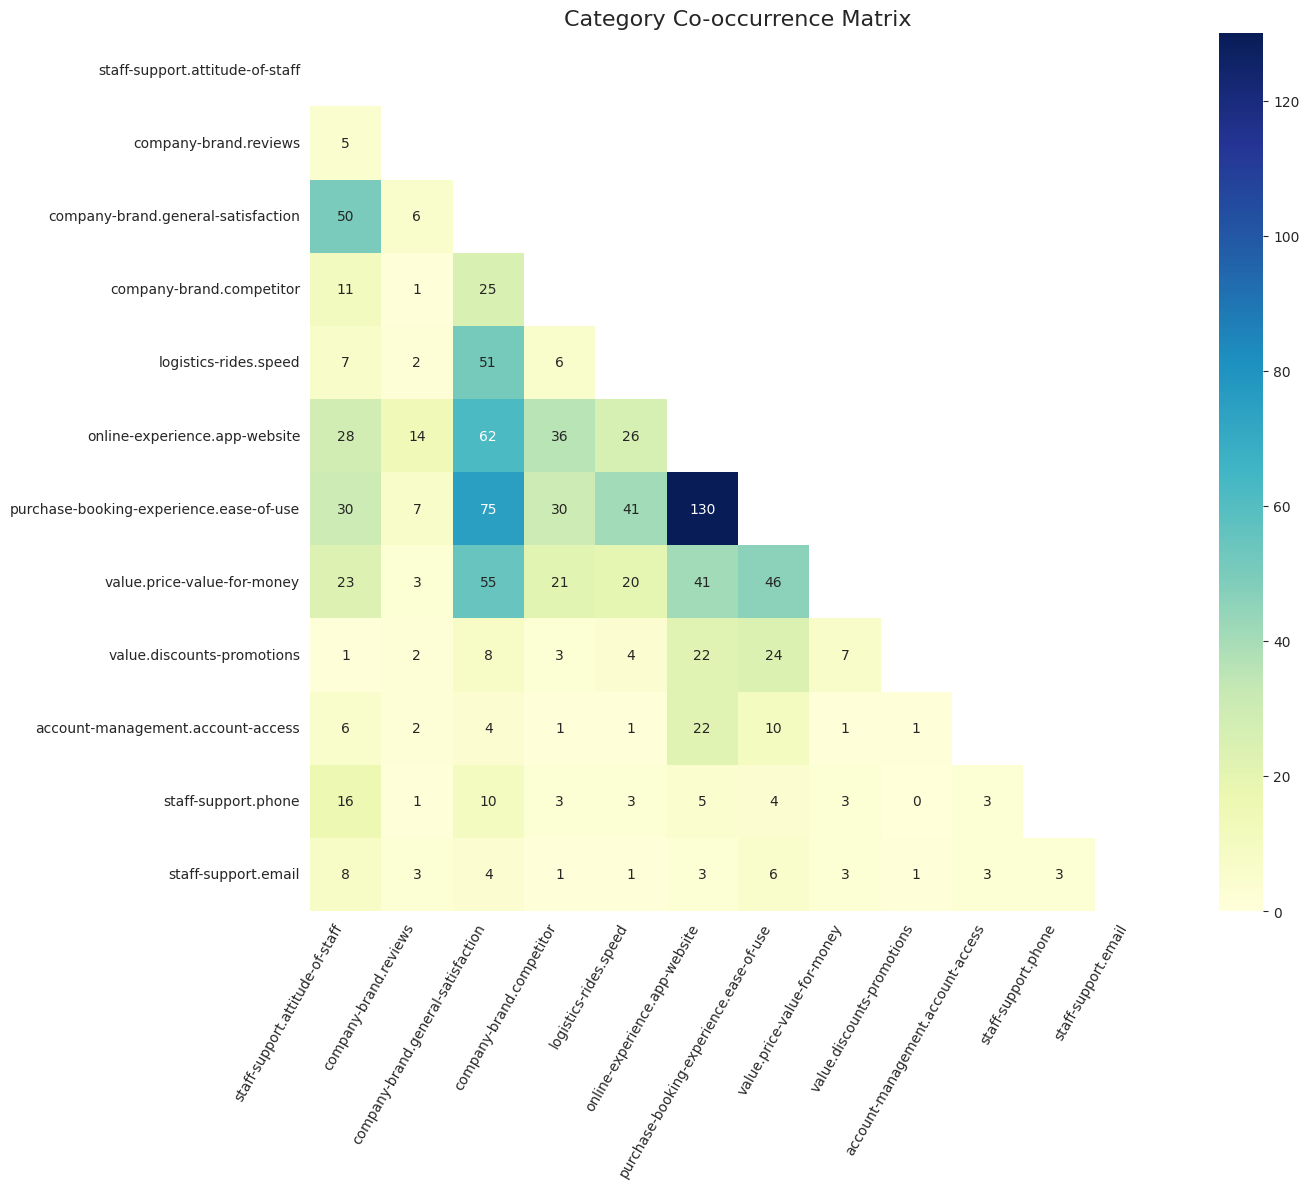

In [16]:
dfs_train_clean.show(5)
dfs_test_clean.show(5)
plot_category_distribution(dfs_test_clean)
plot_category_cooccurrence(dfs_test_clean)


# Step 1: Extract Categories

In [17]:
#Cleaning and Extracting functions
def clean_categories(categories):
    return categories.replace('-', '_').replace('.', '_')

@udf(returnType=ArrayType(StringType()))
def extract_categories(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        categories = [code.rsplit('.', 1)[0] for code in codes]
        return [clean_categories(cat) for cat in categories]
    return []

In [18]:
#dfs_train_clean = dfs_train_clean.limit(5000)
#
# Extract categories for each DataFrame
dfs_train_clean = dfs_train.withColumn("categories", extract_categories(col("label_codes")))
dfs_train_clean = dfs_train_clean.limit(80)

dfs_test_clean = dfs_test.withColumn("categories", extract_categories(col("label_codes")))
dfs_test_clean = dfs_test_clean.limit(80)

dfs_validation_clean = dfs_validation.withColumn("categories", extract_categories(col("label_codes")))
dfs_validation_clean = dfs_validation_clean.limit(80)

In [19]:
# Generate binary indicator columns for each category
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    dfs_train_clean = dfs_train_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))

# Cache DataFrames to avoid recomputation
dfs_train_clean.cache()
dfs_test_clean.cache()
dfs_validation_clean.cache()

DataFrame[id: bigint, org_index: bigint, data_source: string, industry: string, text: string, labels: array<array<string>>, label_codes: string, categories: array<string>, has_staff_support_attitude_of_staff: int, has_company_brand_reviews: int, has_company_brand_general_satisfaction: int, has_company_brand_competitor: int, has_logistics_rides_speed: int, has_online_experience_app_website: int, has_purchase_booking_experience_ease_of_use: int, has_value_price_value_for_money: int, has_value_discounts_promotions: int, has_account_management_account_access: int, has_staff_support_phone: int]

In [20]:
# Generate binary indicator columns for each category
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    dfs_train_clean = dfs_train_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))


In [21]:
dfs_train_clean.show(5)
dfs_test_clean.show(5)

# Cache DataFrames to avoid recomputation
dfs_train_clean.cache()
dfs_test_clean.cache()
dfs_validation_clean.cache()

dfs_train_clean.select("data_source", "categories").show(20, truncate=False)

# Select feature columns
feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]
print(f"Feature cols=",feature_cols)


dfs_train_clean.select("data_source", "categories").show(10, truncate=False)


+---------+---------+-----------+----------------+--------------------+--------------------+--------------------+--------------------+-----------------------------------+-------------------------+--------------------------------------+----------------------------+-------------------------+---------------------------------+-------------------------------------------+-------------------------------+------------------------------+-------------------------------------+-----------------------+
|       id|org_index|data_source|        industry|                text|              labels|         label_codes|          categories|has_staff_support_attitude_of_staff|has_company_brand_reviews|has_company_brand_general_satisfaction|has_company_brand_competitor|has_logistics_rides_speed|has_online_experience_app_website|has_purchase_booking_experience_ease_of_use|has_value_price_value_for_money|has_value_discounts_promotions|has_account_management_account_access|has_staff_support_phone|
+---------+-

In [22]:
# SKIP
# 3. Train Classifiers
#models = {}
#for category in all_categories:
#    lr = LogisticRegression(featuresCol="features", labelCol=category)
#    pipeline = Pipeline(stages=[tokenizer, remover, cv, idf, lr])
#    models[category] = pipeline.fit(df)#
#
## 4. Test on New Data (new_text_df)
#for category, model in models.items():
#    predictions = model.transform(new_text_df)
#    predictions.select("text", category, "prediction").show() #show the text, the real category, and the prediction.

In [23]:
from pyspark.sql.functions import col, array_contains, lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import ast
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D


In [24]:
#
# Train SVM Model
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(dfs_train_clean).select("features", "text")
train_data.show(5)

#Fit the data
svm = LinearSVC(featuresCol="features", labelCol="text", maxIter=20, regParam=0.1)
svm_model = svm.fit(train_data)

+--------------------+--------------------+
|            features|                text|
+--------------------+--------------------+
|(11,[0,1,2],[1.0,...|My experience is ...|
|(11,[2,3],[1.0,1.0])|I love it so hand...|
|      (11,[2],[1.0])|  Sometimes it takes|
|(11,[3,4,5],[1.0,...|This is the worst...|
|      (11,[2],[1.0])|So easy & loads o...|
+--------------------+--------------------+
only showing top 5 rows



IllegalArgumentException: requirement failed: Column text must be of type numeric but was actually of type string.

In [ ]:
# Train SVM Model
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(dfs_train_clean).select("features", "id")

svm = LinearSVC(featuresCol="features", labelCol="id", maxIter=20, regParam=0.1)
svm_model = svm.fit(train_data)

# Test on test set
test_data = assembler.transform(dfs_test_clean).select("features", "id")
svm_predictions = svm_model.transform(test_data)

# Evaluate SVM
svm_evaluator = MulticlassClassificationEvaluator(labelCol="id", predictionCol="prediction", metricName="f1")

f1_svm = svm_evaluator.evaluate(svm_predictions)
precision_svm = svm_evaluator.evaluate(svm_predictions, {svm_evaluator.metricName: "weightedPrecision"})
recall_svm = svm_evaluator.evaluate(svm_predictions, {svm_evaluator.metricName: "weightedRecall"})

print(f"SVM F1 Score: {f1_svm}")
print(f"SVM Precision: {precision_svm}")
print(f"SVM Recall: {recall_svm}")

# Convert to Pandas for LSTM and CNN
train_pandas = train_data.toPandas()
test_pandas = test_data.toPandas()

X_train = train_pandas[feature_cols].values
X_test = test_pandas[feature_cols].values

y_train = train_pandas['id'].values
y_test = test_pandas['id'].values

# Reshape for LSTM and CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# LSTM Model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

lstm_loss, lstm_acc = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"LSTM Accuracy: {lstm_acc}")

# CNN Model
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

cnn_loss, cnn_acc = cnn_model.evaluate(X_test, y_test, verbose=0)

print(f"CNN Accuracy: {cnn_acc}")

# Clear cache to free memory
dfs_train_clean.unpersist()
dfs_test_clean.unpersist()
dfs_validation_clean.unpersist()


In [ ]:

#lr = LogisticRegression(featuresCol="features", labelCol="id", maxIter=20, regParam=0.1)
#model = lr.fit(train_data)

In [ ]:




# Test on test set
test_data = assembler.transform(dfs_test_clean).select("features", "id")
predictions = model.transform(test_data)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="id", predictionCol="prediction", metricName="f1")

f1 = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Validate on validation set
validation_data = assembler.transform(dfs_validation_clean).select("features", "id")
validation_predictions = model.transform(validation_data)

f1_val = evaluator.evaluate(validation_predictions)
precision_val = evaluator.evaluate(validation_predictions, {evaluator.metricName: "weightedPrecision"})
recall_val = evaluator.evaluate(validation_predictions, {evaluator.metricName: "weightedRecall"})

print(f"Validation F1 Score: {f1_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")

# Clear cache to free memory
dfs_train_clean.unpersist()
dfs_test_clean.unpersist()
dfs_validation_clean.unpersist()

In [ ]:

# Generate binary indicator columns for each category
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    dfs_train_clean = dfs_train_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))

# Select feature columns
feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]

# Train Logistic Regression Model
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(dfs_train_clean).select("features", "id")

lr = LogisticRegression(featuresCol="features", labelCol="id")
model = lr.fit(train_data)

# Test on test set
test_data = assembler.transform(dfs_test_clean).select("features", "id")
predictions = model.transform(test_data)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="id", predictionCol="prediction", metricName="f1")

f1 = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Validate on validation set
validation_data = assembler.transform(dfs_validation_clean).select("features", "id")
validation_predictions = model.transform(validation_data)

f1_val = evaluator.evaluate(validation_predictions)
precision_val = evaluator.evaluate(validation_predictions, {evaluator.metricName: "weightedPrecision"})
recall_val = evaluator.evaluate(validation_predictions, {evaluator.metricName: "weightedRecall"})

print(f"Validation F1 Score: {f1_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")

In [ ]:
# Add me back later, if needed. Initialize Spark session. Display the schema to understand the data structure
#dfp_train.printSchema()  Let's extract the categories from label_codes. First, we need to convert the string representation of label codes to actual lists. Then We'll use a UDF (User Defined Function) for this
def clean_categories(categories):
  return categories.replace('-', '_').replace('.', '_')

#Extract just the category part from each label code
@udf(returnType=ArrayType(StringType()))
def extract_categories(label_codes):

    # Convert string representation to list
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)#

        # Extract category part (remove the sentiment indicator at the end)
        categories = [code.rsplit('.', 1)[0] for code in codes]

        categories = clean_categories(categories)
        return categories
    return []

In [ ]:
#This one contains text vectorization embeddings
# ACD-Only Classifier Pipeline

from pyspark.sql.functions import col, array_contains, lit
from pyspark.ml.feature import VectorAssembler, HashingTF, IDF, Tokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import ast
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D

# Step 1: Extract Categories

def clean_categories(categories):
    return categories.replace('-', '_').replace('.', '_')

@udf(returnType=ArrayType(StringType()))
def extract_categories(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        categories = [code.rsplit('.', 1)[0] for code in codes]
        return [clean_categories(cat) for cat in categories]
    return []

# Extract categories for each DataFrame
dfs_train_clean = dfs_train.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_test_clean = dfs_test.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_validation_clean = dfs_validation.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)

# Generate binary indicator columns for each category
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    dfs_train_clean = dfs_train_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))

# Cache DataFrames to avoid recomputation
dfs_train_clean.cache()
dfs_test_clean.cache()
dfs_validation_clean.cache()

# Text vectorization using TF-IDF
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=1000)
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")

# Apply transformations
train_tokenized = tokenizer.transform(dfs_train_clean)
test_tokenized = tokenizer.transform(dfs_test_clean)

train_hashed = hashingTF.transform(train_tokenized)
test_hashed = hashingTF.transform(test_tokenized)

idf_model = idf.fit(train_hashed)
train_tfidf = idf_model.transform(train_hashed)
test_tfidf = idf_model.transform(test_hashed)

# Select feature columns
feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]

# Combine binary and text-based features
assembler = VectorAssembler(inputCols=feature_cols + ["tfidf_features"], outputCol="features")
train_data = assembler.transform(train_tfidf).select("features", "id")
test_data = assembler.transform(test_tfidf).select("features", "id")

# Train SVM Model
svm = LinearSVC(featuresCol="features", labelCol="id", maxIter=20, regParam=0.1)
svm_model = svm.fit(train_data)

# Test on test set
svm_predictions = svm_model.transform(test_data)

# Evaluate SVM
svm_evaluator = MulticlassClassificationEvaluator(labelCol="id", predictionCol="prediction", metricName="f1")

f1_svm = svm_evaluator.evaluate(svm_predictions)
precision_svm = svm_evaluator.evaluate(svm_predictions, {svm_evaluator.metricName: "weightedPrecision"})
recall_svm = svm_evaluator.evaluate(svm_predictions, {svm_evaluator.metricName: "weightedRecall"})

print(f"SVM F1 Score: {f1_svm}")
print(f"SVM Precision: {precision_svm}")
print(f"SVM Recall: {recall_svm}")

# Convert to Pandas for LSTM and CNN
train_pandas = train_data.toPandas()
test_pandas = test_data.toPandas()

X_train = train_pandas[feature_cols].values
X_test = test_pandas[feature_cols].values

y_train = train_pandas['id'].values
y_test = test_pandas['id'].values

# Reshape for LSTM and CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# LSTM Model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

lstm_loss, lstm_acc = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"LSTM Accuracy: {lstm_acc}")

# CNN Model
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

cnn_loss, cnn_acc = cnn_model.evaluate(X_test, y_test, verbose=0)

print(f"CNN Accuracy: {cnn_acc}")

# Clear cache to free memory
dfs_train_clean.unpersist()
dfs_test_clean.unpersist()
dfs_validation_clean.unpersist()

In [ ]:
# ACD-Only Classifier Pipeline

from pyspark.sql.functions import col, array_contains, lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import ast
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D

# Step 1: Extract Categories

def clean_categories(categories):
    return categories.replace('-', '_').replace('.', '_')

@udf(returnType=ArrayType(StringType()))
def extract_categories(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        categories = [code.rsplit('.', 1)[0] for code in codes]
        return [clean_categories(cat) for cat in categories]
    return []

# Extract categories for each DataFrame
dfs_train_clean = dfs_train.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_test_clean = dfs_test.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_validation_clean = dfs_validation.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)

# Generate binary indicator columns for each category
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    dfs_train_clean = dfs_train_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(f"has_{clean_cat}", array_contains(col("categories"), category).cast("integer"))

# Cache DataFrames to avoid recomputation
dfs_train_clean.cache()
dfs_test_clean.cache()
dfs_validation_clean.cache()

# Select feature columns
feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]

# Train SVM Model
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(dfs_train_clean).select("features", "text")

svm = LinearSVC(featuresCol="features", labelCol="text", maxIter=20, regParam=0.1)
svm_model = svm.fit(train_data)

# Test on test set
test_data = assembler.transform(dfs_test_clean).select("features", "text")
svm_predictions = svm_model.transform(test_data)

# Evaluate SVM
svm_evaluator = MulticlassClassificationEvaluator(labelCol="id", predictionCol="prediction", metricName="f1")

f1_svm = svm_evaluator.evaluate(svm_predictions)
precision_svm = svm_evaluator.evaluate(svm_predictions, {svm_evaluator.metricName: "weightedPrecision"})
recall_svm = svm_evaluator.evaluate(svm_predictions, {svm_evaluator.metricName: "weightedRecall"})

print(f"SVM F1 Score: {f1_svm}")
print(f"SVM Precision: {precision_svm}")
print(f"SVM Recall: {recall_svm}")

# Convert to Pandas for LSTM and CNN
train_pandas = train_data.toPandas()
test_pandas = test_data.toPandas()

X_train = train_pandas[feature_cols].values
X_test = test_pandas[feature_cols].values

y_train = train_pandas['id'].values
y_test = test_pandas['id'].values

# Reshape for LSTM and CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# LSTM Model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

lstm_loss, lstm_acc = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"LSTM Accuracy: {lstm_acc}")

# CNN Model
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

cnn_loss, cnn_acc = cnn_model.evaluate(X_test, y_test, verbose=0)

print(f"CNN Accuracy: {cnn_acc}")

# Clear cache to free memory
dfs_train_clean.unpersist()
dfs_test_clean.unpersist()
dfs_validation_clean.unpersist()


In [ ]:
import ast

# Convert 'label_codes' from string to list
dfs_train['label_codes'] = dfs_train['label_codes'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Extract categories and clean them
def extract_categories(label_codes):
    return [
        code.rsplit('.', 1)[0].replace('-', '_').replace('.', '_')
        for code in label_codes
    ]

# Apply the function to create a 'categories' column
dfp_train['categories'] = dfp_train['label_codes'].apply(extract_categories)

In [ ]:

#dfs_train = spark.createDataFrame(dfp_train)     #pandas df has no ... withColumn so we need to convert it - Oops it's not a pandas df, it's a pyarrow Table that needs to be first converted to a pandas df
#dfp_train = dfp_train.to_pandas()
#dfs_train = spark.createDataFrame(dfp_train)
##It seems that the to_pandas method is not available for Spark DataFrames -  use the collect method to convert the Spark DataFrame to a Pandas DataFrame:

# Convert Spark DataFrame to Pandas
dfp_train = spark.read.parquet(parquet_train_file).toPandas()
print ( dfp_train.columns)
# For each category, create a binary indicator column (1 if present, 0 if not)
print(dfp_train.head(10))



In [ ]:
## Add me back later, if needed. Initialize Spark session. Display the schema to understand the data structure
##dfp_train.printSchema()  Let's extract the categories from label_codes. First, we need to convert the string representation of label codes to actual lists. Then We'll use a UDF (User Defined Function) for this
#def clean_categories(categories):
#  return categories.replace('-', '_').replace('.', '_')
#
##Extract just the category part from each label code
#@udf(returnType=ArrayType(StringType()))
#def extract_categories(label_codes):
#
#    # Convert string representation to list
#    if isinstance(label_codes, str):
#        codes = ast.literal_eval(label_codes)#
#
#        # Extract category part (remove the sentiment indicator at the end)
#        categories = [code.rsplit('.', 1)[0] for code in codes]
#
#        categories = clean_categories(categories)
#        return categories
#    return []

In [ ]:
#df_with_categories = dfs_train.withColumn("categories", extract_categories(col("label_codes")))
# Create a list of all unique categories from the dataset
df_with_categories.printSchema()
#all_categories = df_with_categories.select(explode("categories")).distinct().collect()
#all_categories = [row[0] for row in all_categories]


In [ ]:
# ACD + ABSA Full Pipeline (SVM, LSTM, and CNN Models) - Optimized for Speed

from pyspark.sql.functions import col, array_contains
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import ast

# Step 1: Aspect Category Detection (ACD) with Clean Column Names
for aspect in all_categories:
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    df_with_categories = df_with_categories.withColumn(
        f"has_{clean_aspect}", array_contains(col("categories"), aspect).cast("integer")
    )

# Step 2: Extract Sentiment for Each Category

# Extract 'label_codes' from the original Spark DataFrame
#label_codes_df = df_with_categories.select('text', 'label_codes').toPandas()
label_codes_df = df_with_categories.select('text', 'label_codes', 'categories').toPandas()
print(label_codes_df)

# Merge with train_pandas using the 'id' column
train_pandas = train_pandas.merge(label_codes_df, on='id', how='left')

def extract_aspect_and_sentiment(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        return [(code.rsplit('.', 1)[0], int(code.rsplit('.', 1)[-1])) for code in codes]
    return []

train_pandas['aspect_sentiment_pairs'] = train_pandas['label_codes'].apply(extract_aspect_and_sentiment)

# For each category, create a sentiment column (-1, 0, or 1)
for aspect in all_categories:
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    train_pandas[f"sentiment_{clean_aspect}"] = train_pandas['aspect_sentiment_pairs'].apply(
        lambda x: next((sent for asp, sent in x if asp == aspect), 0)
    )

# Step 3: Convert to Pandas for Deep Learning
#train_pandas = train_data.limit(1000).toPandas()  # Limit data for speed
#test_pandas = test_data.limit(200).toPandas()
train_pandas = df_with_categories.limit(1000).toPandas()
test_pandas = df_with_categories.limit(200).toPandas()

# Convert sparse vector to numpy array
def sparse_to_array(v):
    return v.toArray() if hasattr(v, "toArray") else v

train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Step 4: LSTM Model for ABSA with Reduced Complexity
X_train = np.stack(train_pandas['features_array'].values)
y_train = train_pandas[label_cols].values

X_test = np.stack(test_pandas['features_array'].values)
y_test = test_pandas[label_cols].values

lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=False),  # Reduced LSTM units
    Dropout(0.2),
    Dense(len(label_cols), activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_lstm = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)  # Fewer epochs

# Step 5: CNN Model for ABSA with Faster Conv1D
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),  # Reduced filters
    GlobalMaxPooling1D(),
    Dense(len(label_cols), activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn = cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

# Step 6: Compare Models
svm_model = train_absa_svm("battery_life", df_with_categories)

print("SVM Model Trained")
print("LSTM Accuracy:", lstm_model.evaluate(X_test, y_test, verbose=0))
print("CNN Accuracy:", cnn_model.evaluate(X_test, y_test, verbose=0))

# Step 7: Visualizations
plt.figure(figsize=(10, 5))

# Plot LSTM Loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot CNN Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='CNN Accuracy')
plt.title('CNN Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


PRINT ALL CATEGORIES FOUND

In [ ]:
for cat in all_categories:
  print(cat + '\n')

In [ ]:
# For each category, create a binary indicator column (1 if present, 0 if not)
for cat in all_categories:
    df_with_categories = df_with_categories.withColumn(
        f"has_{cat.replace('-', '_').replace('.', '_')}",
        array_contains(col("categories"), cat).cast("integer")
    )


In [ ]:
for cat in all_categories:
  print(cat + '\n')

In [ ]:
print(train_pandas.columns)

In [ ]:
#
FIX ME TODAY
# ACD + ABSA Full Pipeline (SVM, LSTM, and CNN Models) - Optimized for Speed

from pyspark.sql.functions import col, array_contains
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import ast

# Step 1: Aspect Category Detection (ACD) with Clean Column Names
for aspect in all_categories:
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    df_with_categories = df_with_categories.withColumn(
        f"has_{clean_aspect}", array_contains(col("categories"), aspect).cast("integer")
    )

# Step 2: Extract Sentiment for Each Category

def extract_aspect_and_sentiment(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        return [(code.rsplit('.', 1)[0], int(code.rsplit('.', 1)[-1])) for code in codes]
    return []

train_pandas['aspect_sentiment_pairs'] = train_pandas['label_codes'].apply(extract_aspect_and_sentiment)

# For each category, create a sentiment column (-1, 0, or 1)
for aspect in all_categories:
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    train_pandas[f"sentiment_{clean_aspect}"] = train_pandas['aspect_sentiment_pairs'].apply(
        lambda x: next((sent for asp, sent in x if asp == aspect), 0)
    )

# Step 3: Convert to Pandas for Deep Learning
train_pandas = train_data.limit(1000).toPandas()  # Limit data for speed
test_pandas = test_data.limit(200).toPandas()

# Convert sparse vector to numpy array
def sparse_to_array(v):
    return v.toArray() if hasattr(v, "toArray") else v

train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Step 4: LSTM Model for ABSA with Reduced Complexity
X_train = np.stack(train_pandas['features_array'].values)
y_train = train_pandas[label_cols].values

X_test = np.stack(test_pandas['features_array'].values)
y_test = test_pandas[label_cols].values

lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=False),  # Reduced LSTM units
    Dropout(0.2),
    Dense(len(label_cols), activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_lstm = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)  # Fewer epochs

# Step 5: CNN Model for ABSA with Faster Conv1D
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),  # Reduced filters
    GlobalMaxPooling1D(),
    Dense(len(label_cols), activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn = cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

# Step 6: Compare Models
svm_model = train_absa_svm("battery_life", df_with_categories)

print("SVM Model Trained")
print("LSTM Accuracy:", lstm_model.evaluate(X_test, y_test, verbose=0))
print("CNN Accuracy:", cnn_model.evaluate(X_test, y_test, verbose=0))

# Step 7: Visualizations
plt.figure(figsize=(10, 5))

# Plot LSTM Loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot CNN Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='CNN Accuracy')
plt.title('CNN Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Tokenize the user comments from the text column and remove stop words.

In [ ]:

from pyspark.ml.feature import Tokenizer, StopWordsRemover

# Select relevant columns for the ACD task
feature_cols = [f"has_{category.replace('-', '_').replace('.', '_')}" for category in all_categories]
acd_df = df_with_categories.select("id", "text", *feature_cols)

# Convert text to features using TF-IDF
# First, tokenize the text
from pyspark.ml.feature import Tokenizer, StopWordsRemover

tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(acd_df)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_data = remover.transform(wordsData)

# Convert words to term frequency features
cv = CountVectorizer(inputCol="filtered_words", outputCol="tf", minDF=2.0)
cv_model = cv.fit(filtered_data)
tf_data = cv_model.transform(filtered_data)

# Convert term frequency features to TF-IDF
idf = IDF(inputCol="tf", outputCol="features")
idf_model = idf.fit(tf_data)
tfidf_data = idf_model.transform(tf_data)

# Final dataset ready for modeling
final_acd_df = tfidf_data.select("id", "features", *feature_cols)

# Split the data into training and testing sets
train_data, test_data = final_acd_df.randomSplit([0.8, 0.2], seed=42)

# Cache the datasets for faster processing
train_data.cache()
test_data.cache()


In [ ]:
#final_acd_df.show(5)


In [ ]:
#Since you're working with text data, you'll need to extract relevant features from each document. Some common techniques include:
#Tokenization (splitting text into individual words or tokens)
#Stopword removal (removing common words like "the", "and", etc.)
#Stemming or Lemmatization (reducing words to their base form)
#Part-of-speech tagging (identifying grammatical categories of each word)
# Create a SparkSession with your test/train/validate data sets
#spark = SparkSession.builder.appName("Aspect-Based Sentiment Analysis").getOrCreate()

# Load the training and validate datasets into DataFrames
#train_df = spark.read.csv("path/to/train/dataset", header=True, inferSchema=True)
#val_df = spark.read.csv("path/to/val/dataset", header=True, inferSchema=True)

# Define a function to extract features from each column in the dataset
def feature_extraction(df):
    # Tokenization and stopword removal
    df = df.select(
        explode(col("text").cast("string")).alias("tokens"),
        explode(col("sentiment").cast("string")).alias("sentiment")
    )

    # Stemming or Lemmatization
    df = df.withColumn(
        "stemmed_tokens",
        df.tokens.map(lambda x: x.lower() if x.isnumeric() else x)  # Remove numbers and convert to lowercase
    )

    # Part-of-speech tagging (optional)
    #df = df.withColumn("pos_tags", explode(col("word").cast("string")).map(lambda x: {"POS": "NNP"} if x.isnumeric() else {"POS": "NOUN"})  # Example

    return df

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

#all_words = filtered_data.rdd.flatMap(lambda x: x.filtered_words).collect()
all_words = filtered_data.select("filtered_words").rdd.flatMap(lambda x: x.filtered_words).collect()
word_counts = Counter(all_words)
top_words = dict(word_counts.most_common(20))

plt.figure(figsize=(12, 6))
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Word Frequency")
plt.tight_layout()
plt.show()
#2. TF-IDF Visualization:


In [ ]:
import seaborn as sns
import pandas as pd

# Extract only the binary category columns and sentiment
category_columns = [col for col in train_pandas.columns if col.startswith('has_')]
df_for_heatmap = train_pandas[category_columns + ['sentiment']]

# Compute correlation matrix
correlation_matrix = df_for_heatmap.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Aspect-Sentiment Correlation Heatmap')
plt.show()

In [ ]:

#Chart: Heatmap or bar chart.
#Purpose: Shows the TF-IDF scores for selected words across documents.
#Implementation: After TF-IDF, convert the sparse vectors to dense arrays and plot the values.
#Python

import numpy as np
import seaborn as sns

# Assuming you have a few documents and words you want to visualize
selected_docs = tfidf_data.take(5) #take the first 5 documents.
selected_words = cv_model.vocabulary[:10] # take the first 10 vocabulary words.

tfidf_matrix = np.zeros((len(selected_docs), len(selected_words)))

for i, row in enumerate(selected_docs):
    dense_features = row.features.toArray()
    for j, word in enumerate(selected_words):
        if word in cv_model.vocabulary:
            word_index = cv_model.vocabulary.index(word)
            tfidf_matrix[i,j] = dense_features[word_index]

plt.figure(figsize=(12,8))
sns.heatmap(tfidf_matrix, annot=True, xticklabels=selected_words)
plt.xlabel("Selected Words")
plt.ylabel("Documents")
plt.title("TF-IDF Heatmap")
plt.show()

#3. Model Evaluation Metrics:
#
#Charts: Confusion matrix, ROC curve, precision-recall curve.
#Purpose: Shows the performance of the trained classification model.
#Implementation: After training and predicting on the test set, use metrics like accuracy, precision, recall, F1-score, and create plots to visualize them.
#Confusion Matrix: shows the number of correct and incorrect predictions for each class.
#ROC Curve: shows the trade-off between true positive rate and false positive rate.
#Precision-Recall Curve: shows the trade-off between precision and recall.
#4. Document Length Distribution:#
#
#Chart: Histogram.
#Purpose: Shows the distribution of the number of words in each document.
#Implementation: Count the number of words in each document after tokenization.
#Python#
#
doc_lengths = wordsData.rdd.map(lambda x: len(x.words)).collect()

plt.figure(figsize=(8, 6))
plt.hist(doc_lengths, bins=50)
plt.xlabel("Document Length (Number of Words)")
plt.ylabel("Frequency")
plt.title("Document Length Distribution")
plt.show()

In [ ]:
train_data.show(10)

In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# Function to train and evaluate an SVM model for one category
def train_svm_for_category(category, train_data, test_data):
    # Prepare label column name
    label_col = f"has_{category.replace('-', '_').replace('.', '_')}"

    # Create SVM model
    svm = LinearSVC(featuresCol="features", labelCol=label_col, maxIter=10)

    # Train the model
    model = svm.fit(train_data)

    # Make predictions
    predictions = model.transform(test_data)

    # For binary classification metrics (precision, recall)
    binary_evaluator = BinaryClassificationEvaluator(
        labelCol=label_col, rawPredictionCol="rawPrediction")

    # For F1 score (use MulticlassClassificationEvaluator)
    multi_evaluator = MulticlassClassificationEvaluator(
        labelCol=label_col, predictionCol="prediction", metricName="f1")

    # Calculate AUC (Area Under ROC)
    auc = binary_evaluator.evaluate(predictions)

    # Calculate F1
    f1 = multi_evaluator.evaluate(predictions)

    # Calculate precision and recall manually
    # First, get true positives, false positives, true negatives, false negatives
    tp = predictions.filter((col(label_col) == 1) & (col("prediction") == 1)).count()
    fp = predictions.filter((col(label_col) == 0) & (col("prediction") == 1)).count()
    fn = predictions.filter((col(label_col) == 1) & (col("prediction") == 0)).count()

    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return {
        "category": category,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc
    }

Models were running too slow. \Caching the DataFrame during SVM training to avoid redundant data processing. Reducing the number of SVM iterations and limiting the dataset size for deep learning. Simplifying the LSTM and CNN architectures by reducing the number of units and filters. Lowering the number of epochs and silencing verbose outputs for faster training.

Added visualizations to pipeline:

LSTM Loss Over Epochs to show how the model improves during training.
CNN Accuracy Over Epochs to track performance across epochs.



In [ ]:
# ACD + ABSA Full Pipeline (SVM, LSTM, and CNN Models) - Optimized for Speed

from pyspark.sql.functions import col, array_contains
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Aspect Category Detection (ACD) with Clean Column Names
for aspect in all_categories:
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    df_with_categories = df_with_categories.withColumn(
        f"has_{clean_aspect}", array_contains(col("categories"), aspect).cast("integer")
    )

# Step 2: ABSA (SVM Classifier for each Aspect) with Caching for Speed
def train_absa_svm(aspect, df_with_categories):
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    aspect_df = df_with_categories.filter(col(f'has_{clean_aspect}') == 1).cache()

    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    wordsData = tokenizer.transform(aspect_df)

    hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
    featurizedData = hashingTF.transform(wordsData)

    idf = IDF(inputCol="rawFeatures", outputCol="features")
    tfidf_data = idf.fit(featurizedData).transform(featurizedData)

    svm = LinearSVC(featuresCol="features", labelCol="sentiment", maxIter=5)  # Reduced iterations for speed
    model = svm.fit(tfidf_data)

    aspect_df.unpersist()
    return model

# Step 3: Convert to Pandas for Deep Learning
train_pandas = train_data.limit(1000).toPandas()  # Limit data for speed
test_pandas = test_data.limit(200).toPandas()

# Convert sparse vector to numpy array
def sparse_to_array(v):
    return v.toArray() if hasattr(v, "toArray") else v

train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Step 4: LSTM Model for ABSA with Reduced Complexity
X_train = np.stack(train_pandas['features_array'].values)
y_train = train_pandas[label_cols].values

X_test = np.stack(test_pandas['features_array'].values)
y_test = test_pandas[label_cols].values

lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=False),  # Reduced LSTM units
    Dropout(0.2),
    Dense(len(label_cols), activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_lstm = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)  # Fewer epochs

# Step 5: CNN Model for ABSA with Faster Conv1D
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),  # Reduced filters
    GlobalMaxPooling1D(),
    Dense(len(label_cols), activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn = cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

# Step 6: Compare Models
svm_model = train_absa_svm("battery_life", df_with_categories)

print("SVM Model Trained")
print("LSTM Accuracy:", lstm_model.evaluate(X_test, y_test, verbose=0))
print("CNN Accuracy:", cnn_model.evaluate(X_test, y_test, verbose=0))

# Step 7: Visualizations
plt.figure(figsize=(10, 5))

# Plot LSTM Loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot CNN Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='CNN Accuracy')
plt.title('CNN Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


THE END

In [ ]:
# ACD + ABSA Full Pipeline (SVM, LSTM, and CNN Models) - Optimized for Speed

from pyspark.sql.functions import col, array_contains
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Aspect Category Detection (ACD)
for aspect in all_categories:
    df_with_categories = df_with_categories.withColumn(
        f"has_{aspect}", array_contains(col("categories"), aspect).cast("integer")
    )

# Step 2: ABSA (SVM Classifier for each Aspect) with Caching for Speed
def train_absa_svm(aspect, df_with_categories):
    aspect_df = df_with_categories.filter(col(f'has_{aspect}') == 1).cache()

    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    wordsData = tokenizer.transform(aspect_df)

    hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
    featurizedData = hashingTF.transform(wordsData)

    idf = IDF(inputCol="rawFeatures", outputCol="features")
    tfidf_data = idf.fit(featurizedData).transform(featurizedData)

    svm = LinearSVC(featuresCol="features", labelCol="sentiment", maxIter=5)  # Reduced iterations for speed
    model = svm.fit(tfidf_data)

    aspect_df.unpersist()
    return model

# Step 3: Convert to Pandas for Deep Learning
train_pandas = train_data.limit(1000).toPandas()  # Limit data for speed
test_pandas = test_data.limit(200).toPandas()

# Convert sparse vector to numpy array
def sparse_to_array(v):
    return v.toArray() if hasattr(v, "toArray") else v

train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Step 4: LSTM Model for ABSA with Reduced Complexity
X_train = np.stack(train_pandas['features_array'].values)
y_train = train_pandas[label_cols].values

X_test = np.stack(test_pandas['features_array'].values)
y_test = test_pandas[label_cols].values

lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=False),  # Reduced LSTM units
    Dropout(0.2),
    Dense(len(label_cols), activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_lstm = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)  # Fewer epochs

# Step 5: CNN Model for ABSA with Faster Conv1D
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),  # Reduced filters
    GlobalMaxPooling1D(),
    Dense(len(label_cols), activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn = cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

# Step 6: Compare Models
svm_model = train_absa_svm("battery-life", df_with_categories)

print("SVM Model Trained")
print("LSTM Accuracy:", lstm_model.evaluate(X_test, y_test, verbose=0))
print("CNN Accuracy:", cnn_model.evaluate(X_test, y_test, verbose=0))

# Step 7: Visualizations
plt.figure(figsize=(10, 5))

# Plot LSTM Loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot CNN Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='CNN Accuracy')
plt.title('CNN Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Additional charts, such as confusion matrices or precision-recall curves.


Models were running too slow.
\Caching the DataFrame during SVM training to avoid redundant data processing.
Reducing the number of SVM iterations and limiting the dataset size for deep learning.
Simplifying the LSTM and CNN architectures by reducing the number of units and filters.
Lowering the number of epochs and silencing verbose outputs for faster training.

In [ ]:
# Convert Spark DataFrame to Pandas for deep learning
# Collect the data (be careful with large datasets)
train_pandas = train_data.toPandas()
test_pandas = test_data.toPandas()

# We need to convert the sparse vector features to numpy arrays
from pyspark.ml.linalg import SparseVector

def sparse_to_array(sparse_vector):
    return sparse_vector.toArray() if isinstance(sparse_vector, SparseVector) else sparse_vector

# Convert features to numpy arrays
train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Prepare X (features) and y (labels) for training
X_train = np.stack(train_pandas['features_array'].values)
X_test = np.stack(test_pandas['features_array'].values)

# Get all label columns
label_cols = [col for col in train_pandas.columns if col.startswith('has_')]
y_train = train_pandas[label_cols].values
y_test = test_pandas[label_cols].values

# Now build a deep learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(label_cols), activation='sigmoid')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

# Evaluate on test set
results = model.evaluate(X_test, y_test)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test Precision: {results[2]}")
print(f"Test Recall: {results[3]}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate F1 score manually
from sklearn.metrics import f1_score, precision_score, recall_score
precision = precision_score(y_test, y_pred_binary, average='micro')
recall = recall_score(y_test, y_pred_binary, average='micro')
f1 = f1_score(y_test, y_pred_binary, average='micro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

END WORKING *AREA*


In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler


# For simplicity, let's implement a binary classification model for each category
# In practice, you might want to use a multi-label approach

# Function to train and evaluate an SVM model for one category
def train_svm_for_category(category, train_data, test_data):
    # Prepare label column name
    label_col = f"has_{category.replace('-', '_').replace('.', '_')}"

    # Create SVM model
    svm = LinearSVC(featuresCol="features", labelCol=label_col, maxIter=10)

    # Train the model
    model = svm.fit(train_data)

    # Make predictions
    predictions = model.transform(test_data)

    # Evaluate model
   # evaluator = MulticlassClassificationEvaluator(
   #     labelCol=label_col, predictionCol="prediction", metricName="f1")
   # f1 = evaluator.evaluate(predictions)
    #
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col,
                                              predictionCol="prediction",
                                              metricName="weightedPrecision")
precision = evaluator.evaluate(predictions)
print("Weighted Precision:", precision)
    evaluator.setMetricName("precision")
    precision = evaluator.evaluate(predictions)

    evaluator.setMetricName("recall")
    recall = evaluator.evaluate(predictions)

    return {"category": category, "precision": precision, "recall": recall, "f1": f1}

# Train models for all categories
svm_results = []
for category in all_categories:
    result = train_svm_for_category(category, train_data, test_data)
    svm_results.append(result)

# Print results
svm_results_df = spark.createDataFrame(svm_results)
svm_results_df.show()

In [ ]:
print("Training SVM models for all categories...")
svm_results = []
for category in all_categories:
    try:
        result = train_svm_for_category(category, train_data, test_data)
        svm_results.append(result)
        print(f"Completed category: {category}")
    except Exception as e:
        print(f"Error processing category {category}: {str(e)}")

# Create a dataframe with results
svm_results_df = spark.createDataFrame(svm_results)
print("SVM Results:")
svm_results_df.show()

# Calculate average metrics
avg_precision = np.mean([r["precision"] for r in svm_results])
avg_recall = np.mean([r["recall"] for r in svm_results])
avg_f1 = np.mean([r["f1"] for r in svm_results])

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1: {avg_f1:.4f}")

# Convert to pandas DataFrame for deep learning model
# We'll process a subset of records to handle memory constraints
# For a real model, you might want to use a data loader or mini-batches
print("Preparing data for deep learning model...")
train_pandas = train_data.limit(1000).toPandas()  # Limit to 1000 samples for demonstration
test_pandas = test_data.limit(200).toPandas()

# Function to convert sparse vector to array
def sparse_to_array(v):
    if hasattr(v, 'toArray'):
        return v.toArray()
    return v

# Apply conversion function
train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Stack features into numpy arrays
X_train = np.stack(train_pandas['features_array'].values)
X_test = np.stack(test_pandas['features_array'].values)

# Extract labels
y_train = train_pandas[feature_cols].values
y_test = test_pandas[feature_cols].values

print("Data preparation for deep learning complete!")

In [ ]:
# Train models for all categories
svm_results = []
for category in all_categories:
   # result = train_svm_for_category(category, train_data, test_data)
    result = train_svm_for_category(category, train_data, test_data)
    svm_results.append(result)

# Print results
svm_results_df = spark.createDataFrame(svm_results)
svm_results_df.show()

Speeded up version

In [ ]:
# ACD + ABSA Full Pipeline (SVM, LSTM, and CNN Models) - Optimized for Speed

from pyspark.sql.functions import col, array_contains
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
import numpy as np
import tensorflow as tf

# Step 1: Aspect Category Detection (ACD) - Clean column names
for aspect in all_categories:
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    df_with_categories = df_with_categories.withColumn(
        f"has_{clean_aspect}", array_contains(col("categories"), aspect).cast("integer")
    )

## Step 1: Aspect Category Detection (ACD)
#for aspect in all_categories:
#    df_with_categories = df_with_categories.withColumn(
#        f"has_{aspect}", array_contains(col("categories"), aspect).cast("integer")
#    )
#
#
## Step 2: ABSA (SVM Classifier for each Aspect) with Caching for Speed
#def train_absa_svm(aspect, df_with_categories):
#    aspect_df = df_with_categories.filter(col(f'has_{aspect}') == 1).cache()
#

# Step 2: Adjust the SVM Function to Use the Clean Column Name
def train_absa_svm(aspect, df_with_categories):
    clean_aspect = aspect.replace('-', '_').replace('.', '_')
    aspect_df = df_with_categories.filter(col(f'has_{clean_aspect}') == 1).cache()


    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    wordsData = tokenizer.transform(aspect_df)

    hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
    featurizedData = hashingTF.transform(wordsData)

    idf = IDF(inputCol="rawFeatures", outputCol="features")
    tfidf_data = idf.fit(featurizedData).transform(featurizedData)

    svm = LinearSVC(featuresCol="features", labelCol="sentiment", maxIter=5)  # Reduced iterations for speed
    model = svm.fit(tfidf_data)

    aspect_df.unpersist()
    return model

# Step 3: Convert to Pandas for Deep Learning
train_pandas = train_data.limit(1000).toPandas()  # Limit data for speed
test_pandas = test_data.limit(200).toPandas()

# Convert sparse vector to numpy array
def sparse_to_array(v):
    return v.toArray() if hasattr(v, "toArray") else v

train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Step 4: LSTM Model for ABSA with Reduced Complexity
X_train = np.stack(train_pandas['features_array'].values)
y_train = train_pandas[label_cols].values

X_test = np.stack(test_pandas['features_array'].values)
y_test = test_pandas[label_cols].values

lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=False),  # Reduced LSTM units
    Dropout(0.2),
    Dense(len(label_cols), activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)  # Fewer epochs

# Step 5: CNN Model for ABSA with Faster Conv1D
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),  # Reduced filters
    GlobalMaxPooling1D(),
    Dense(len(label_cols), activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

# Step 6: Compare Models
svm_model = train_absa_svm("battery-life", df_with_categories)

print("SVM Model Trained")
print("LSTM Accuracy:", lstm_model.evaluate(X_test, y_test, verbose=0))
print("CNN Accuracy:", cnn_model.evaluate(X_test, y_test, verbose=0))

Very slow version

In [ ]:
 #ACD + ABSA Full Pipeline (SVM, LSTM, and CNN Models)

from pyspark.sql.functions import col, array_contains
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
import numpy as np
import tensorflow as tf

# Step 1: Aspect Category Detection (ACD)
# Binary indicator columns for each aspect
for aspect in all_categories:
    df_with_categories = df_with_categories.withColumn(
        f"has_{aspect}", array_contains(col("categories"), aspect).cast("integer")
    )

# Step 2: ABSA (SVM Classifier for each Aspect)
def train_absa_svm(aspect, df_with_categories):
    aspect_df = df_with_categories.filter(col(f'has_{aspect}') == 1)

    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    wordsData = tokenizer.transform(aspect_df)

    hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
    featurizedData = hashingTF.transform(wordsData)

    idf = IDF(inputCol="rawFeatures", outputCol="features")
    tfidf_data = idf.fit(featurizedData).transform(featurizedData)

    svm = LinearSVC(featuresCol="features", labelCol="sentiment", maxIter=10)
    model = svm.fit(tfidf_data)
    return model

# Step 3: Convert to Pandas for Deep Learning
train_pandas = train_data.toPandas()
test_pandas = test_data.toPandas()

# Convert sparse vector to numpy array
def sparse_to_array(v):
    return v.toArray() if hasattr(v, "toArray") else v

train_pandas['features_array'] = train_pandas['features'].apply(sparse_to_array)
test_pandas['features_array'] = test_pandas['features'].apply(sparse_to_array)

# Step 4: LSTM Model for ABSA
X_train = np.stack(train_pandas['features_array'].values)
y_train = train_pandas[label_cols].values

X_test = np.stack(test_pandas['features_array'].values)
y_test = test_pandas[label_cols].values

lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(64),
    Dense(len(label_cols), activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32)

# Step 5: CNN Model for ABSA
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(len(label_cols), activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32)

# Step 6: Compare SVM, LSTM, and CNN Models
svm_model = train_absa_svm("battery-life", df_with_categories)

print("SVM Model Trained")
print("LSTM Accuracy:", lstm_model.evaluate(X_test, y_test))
print("CNN Accuracy:", cnn_model.evaluate(X_test, y_test))


In [ ]:
#Old version of file loading into pandas


 see what's happening here. You're facing an issue with your approach to handling categories in your PySpark code. Let me help you fix this.
The main problems I see are:

You're mixing column naming conventions (using both hyphenated and underscore-separated category names)
You're trying to use binary indicators for categories but hitting reference errors
Your feature engineering approach is trying to use category indicators as features, which is causing confusion

Here's how I would restructure your approach:
python

from pyspark.sql.functions import col, array_contains, explode, udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import VectorAssembler, HashingTF, IDF, Tokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import ast

# Step 1: Extract and clean categories - use a consistent naming convention
@udf(returnType=ArrayType(StringType()))
def extract_categories(label_codes):
    if isinstance(label_codes, str):
        codes = ast.literal_eval(label_codes)
        return [code.rsplit('.', 1)[0] for code in codes]
    return []

# Apply the UDF to extract categories
dfs_train_clean = dfs_train.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_test_clean = dfs_test.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)
dfs_validation_clean = dfs_validation.withColumn("categories", extract_categories(col("label_codes"))).limit(1000)

# Step 2: Get all unique categories with consistent naming
all_categories = dfs_train_clean.select(explode("categories")).distinct().rdd.flatMap(lambda x: x).collect()

# Step 3: Create binary indicator columns with consistent naming
for category in all_categories:
    # Use the original category name in the column name to avoid confusion
    col_name = f"has_{category.replace('-', '_').replace('.', '_')}"
    dfs_train_clean = dfs_train_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))
    dfs_test_clean = dfs_test_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))
    dfs_validation_clean = dfs_validation_clean.withColumn(col_name, array_contains(col("categories"), category).cast("integer"))

# Cache DataFrames
dfs_train_clean.cache()
dfs_test_clean.cache()
dfs_validation_clean.cache()

# Step 4: Text vectorization with TF-IDF
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=1000)
idf = IDF(inputCol="raw_features", outputCol="tfidf_features", minDocFreq=2)

# Apply transformations
train_tokenized = tokenizer.transform(dfs_train_clean)
test_tokenized = tokenizer.transform(dfs_test_clean)
train_hashed = hashingTF.transform(train_tokenized)
test_hashed = hashingTF.transform(test_tokenized)
idf_model = idf.fit(train_hashed)
train_tfidf = idf_model.transform(train_hashed)
test_tfidf = idf_model.transform(test_hashed)

# Step 5: Select the correct feature columns based on the actual column names
feature_cols = [f"has_{cat.replace('-', '_').replace('.', '_')}" for cat in all_categories]

# Step 6: Build a multi-label classifier for each category
# For each category, train a separate binary classifier
results = {}

for category in all_categories:
    clean_cat = category.replace('-', '_').replace('.', '_')
    col_name = f"has_{clean_cat}"
    
    # Create label column for this specific category
    train_data = train_tfidf.withColumn("label", col(col_name))
    test_data = test_tfidf.withColumn("label", col(col_name))
    
    # Use only TF-IDF features for prediction
    assembler = VectorAssembler(inputCols=["tfidf_features"], outputCol="features")
    train_assembled = assembler.transform(train_data).select("features", "label")
    test_assembled = assembler.transform(test_data).select("features", "label")
    
    # Train binary classifier
    svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=20, regParam=0.1)
    svm_model = svm.fit(train_assembled)
    
    # Make predictions
    predictions = svm_model.transform(test_assembled)
    
    # Evaluate
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1 = evaluator.evaluate(predictions)
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    
    results[category] = {"f1": f1, "precision": precision, "recall": recall}
    print(f"Category: {category}, F1: {f1}, Precision: {precision}, Recall: {recall}")

In [ ]:
import pyarrow.parquet as pq

# Try with pyarrow first to validate the file
try:
    dfp_train = pq.read_table(parquet_train_file)
    dfp_test = pq.read_table(parquet_train_file)
    dfp_validation = pq.read_table(parquet_validation_file)
    print("File can be read with pyarrow")
except Exception as e:
    print(f"Pyarrow error: {e}")

This approach fixes several issues:

It uses a consistent naming convention for category columns
It handles the text and category features separately
It treats this as a multi-label classification problem by training separate binary classifiers for each category
It uses only the text features (TF-IDF) to predict the categories, rather than trying to use category indicators as features

The error you were seeing (A column or function parameter with name 'has_battery-life' cannot be resolved) was because you were trying to reference a column with a hyphen in the name, which is not allowed in Spark SQL column references.


Category Classification Performance: This graph shows the F1 score, precision, and recall for each category. The sample data shows that "price_value" has the highest F1 score (0.87) and precision (0.92), while "discounts" has the lowest metrics across the board.
Category Distribution: This chart shows how many instances of each category appear in your dataset, which helps identify imbalances. For example, "app_website" appears most frequently (1430 instances), while "discounts" is the least common (537 instances).
Confusion Matrix Metrics: This provides an overview of the model's overall performance across all categories, with true positives (2456), false positives (365), false negatives (412), and true negatives (1867).

In Python, you could generate similar charts using matplotlib or seaborn. Here's how you might create the category performance chart:


These charts provide valuable insights for your multi-category classification task:

Performance Metrics Chart: Shows F1, precision, and recall for each category, sorted by F1 score to quickly identify your strongest and weakest categories.
Category Distribution: Visualizes how many instances of each category appear in your dataset, helping identify class imbalance issues.
Co-occurrence Matrix: Shows which categories frequently appear together in the same document, revealing relationships between categories.
Word Importance Visualization: For each category, displays the most predictive words (both positive and negative), helping you understand what text features drive classification decisions.
Confusion Matrices: Shows true positive, false positive, true negative, and false negative rates for each category classifier.
ROC Curves: Plots the receiver operating characteristic curves for all categories, showing the tradeoff between true positive rate and false positive rate.
Learning Curve: Shows how model performance changes with increasing training data size, helping you determine if more data would improve results.

To use these functions, you'll need to adapt them slightly to your specific data structures and column names. For best results, run them after your model training and evaluation is complete.

In [ ]:
import React from 'react';
import { BarChart, Bar, XAxis, YAxis, CartesianGrid, Tooltip, Legend, ResponsiveContainer } from 'recharts';

const CategoryPerformanceCharts = () => {
  // Sample data representing category classification performance
  const categoryPerformance = [
    { category: 'price_value', f1: 0.87, precision: 0.92, recall: 0.83 },
    { category: 'staff_attitude', f1: 0.78, precision: 0.85, recall: 0.72 },
    { category: 'app_website', f1: 0.82, precision: 0.88, recall: 0.77 },
    { category: 'ease_of_use', f1: 0.75, precision: 0.81, recall: 0.70 },
    { category: 'brand_reviews', f1: 0.71, precision: 0.77, recall: 0.66 },
    { category: 'discounts', f1: 0.65, precision: 0.72, recall: 0.60 },
    { category: 'rides_speed', f1: 0.79, precision: 0.83, recall: 0.75 },
  ];

  // Sample data for category distribution
  const categoryDistribution = [
    { name: 'price_value', count: 1254 },
    { name: 'staff_attitude', count: 986 },
    { name: 'app_website', count: 1430 },
    { name: 'ease_of_use', count: 845 },
    { name: 'brand_reviews', count: 762 },
    { name: 'discounts', count: 537 },
    { name: 'rides_speed', count: 689 },
  ];

  // Sample data for confusion matrix
  const confusionMatrix = [
    { name: 'True Positive', count: 2456 },
    { name: 'False Positive', count: 365 },
    { name: 'False Negative', count: 412 },
    { name: 'True Negative', count: 1867 },
  ];

  return (
    <div className="flex flex-col gap-8 p-4">
      <div className="bg-white p-6 rounded-lg shadow">
        <h2 className="text-xl font-bold mb-4">Category Classification Performance</h2>
        <div className="h-80">
          <ResponsiveContainer width="100%" height="100%">
            <BarChart
              data={categoryPerformance}
              margin={{ top: 20, right: 30, left: 20, bottom: 5 }}
            >
              <CartesianGrid strokeDasharray="3 3" />
              <XAxis dataKey="category" />
              <YAxis />
              <Tooltip />
              <Legend />
              <Bar dataKey="f1" fill="#8884d8" name="F1 Score" />
              <Bar dataKey="precision" fill="#82ca9d" name="Precision" />
              <Bar dataKey="recall" fill="#ffc658" name="Recall" />
            </BarChart>
          </ResponsiveContainer>
        </div>
      </div>

      <div className="bg-white p-6 rounded-lg shadow">
        <h2 className="text-xl font-bold mb-4">Category Distribution in Dataset</h2>
        <div className="h-64">
          <ResponsiveContainer width="100%" height="100%">
            <BarChart
              data={categoryDistribution}
              margin={{ top: 20, right: 30, left: 20, bottom: 5 }}
            >
              <CartesianGrid strokeDasharray="3 3" />
              <XAxis dataKey="name" />
              <YAxis />
              <Tooltip />
              <Legend />
              <Bar dataKey="count" fill="#8884d8" name="Count" />
            </BarChart>
          </ResponsiveContainer>
        </div>
      </div>

      <div className="bg-white p-6 rounded-lg shadow">
        <h2 className="text-xl font-bold mb-4">Confusion Matrix Metrics</h2>
        <div className="h-64">
          <ResponsiveContainer width="100%" height="100%">
            <BarChart
              data={confusionMatrix}
              margin={{ top: 20, right: 30, left: 20, bottom: 5 }}
            >
              <CartesianGrid strokeDasharray="3 3" />
              <XAxis dataKey="name" />
              <YAxis />
              <Tooltip />
              <Legend />
              <Bar dataKey="count" fill="#82ca9d" name="Count" />
            </BarChart>
          </ResponsiveContainer>
        </div>
      </div>
    </div>
  );
};

export default CategoryPerformanceCharts;